In [1]:
# !pip install -q datasets  # tokenizers is optional, we default to a tiny char tokenizer

import os, sys, math, random, textwrap
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
from datasets import load_dataset

# Point PYTHONPATH to your TTML build (adjust if needed)
sys.path.append(f'{os.environ["HOME"]}/git/tt-metal/tt-train/build/sources/ttml')
import _ttml

# Repro
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)

set_seed(42)

@dataclass
class TrainConfig:
    seq_len: int = 256          # context length
    batch_size: int = 64
    steps: int = 5000              # total train steps
    eval_every: int = 200
    lr: float = 3e-4
    beta1: float = 0.9
    beta2: float = 0.999
    eps: float = 1e-8
    weight_decay: float = 0.01
    n_layer: int = 6
    n_head: int = 6
    n_embd: int = 384
    seed: int = 42
    use_bpe: bool = False          # optional: use HF tokenizers BPE instead of char tokenizer


In [2]:
from datasets import load_dataset

def load_shakespeare_text() -> str:
    """
    Returns the full Tiny Shakespeare corpus as a single string.
    Tries a script-free HF dataset first; falls back to raw GitHub text.
    Compatible with datasets==3.6.0 (no dataset scripts).
    """
    # 1) Try a Hub repo that stores data files directly (no Python script)
    try:
        ds = load_dataset("Trelis/tiny-shakespeare")  # CSV-backed; generic loader
        split = "train" if "train" in ds else list(ds.keys())[0]
        # pick the first string column
        str_cols = [c for c in ds[split].column_names if ds[split].features[c].dtype == "string"]
        col = str_cols[0] if str_cols else ds[split].column_names[0]
        text = "\n".join(ds[split][col])
        if len(text) > 0:
            return text
    except Exception as e:
        print(f"[info] HF repo path failed ({type(e).__name__}: {e}). Falling back to raw text URL.")

    # 2) Fallback: raw GitHub file + "text" loader (one line per row)
    ds = load_dataset(
        "text",
        data_files={"train": "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"},
    )
    text = "\n".join(ds["train"]["text"])
    return text
# --- Character-level tokenizer (default) ---
class CharTokenizer:
    def __init__(self, text: str):
        # Sorted stable alphabet for reproducibility
        chars = sorted(list(set(text)))
        self.stoi: Dict[str, int] = {ch: i for i, ch in enumerate(chars)}
        self.itos: List[str] = chars

    @property
    def vocab_size(self) -> int:
        return len(self.itos)

    def encode(self, s: str) -> List[int]:
        return [self.stoi[c] for c in s]

    def decode(self, ids: List[int]) -> str:
        return "".join(self.itos[i] for i in ids)

# --- Optional: BPE tokenizer using HF `tokenizers` ---
def build_bpe_tokenizer_from_text(tmp_corpus_path: str = "shakespeare_corpus.txt"):
    # Minimal training pipeline; produces subword tokens (not pure char)
    # Only used if cfg.use_bpe=True
    from tokenizers import Tokenizer
    from tokenizers.models import BPE
    from tokenizers.trainers import BpeTrainer
    from tokenizers.pre_tokenizers import ByteLevel

    tok = Tokenizer(BPE(unk_token="[UNK]"))
    tok.pre_tokenizer = ByteLevel()
    trainer = BpeTrainer(vocab_size=8192, special_tokens=["[UNK]", "[BOS]", "[EOS]"])
    tok.train(files=[tmp_corpus_path], trainer=trainer)
    return tok

# --- Build tokenizer + dataset splits ---
def prepare_data(cfg: TrainConfig):
    text = load_shakespeare_text()

    if cfg.use_bpe:
        # Train a tiny BPE tokenizer on the fly
        with open("shakespeare_corpus.txt", "w", encoding="utf-8") as f:
            f.write(text)
        bpe = build_bpe_tokenizer_from_text("shakespeare_corpus.txt")

        def encode_all(t: str) -> np.ndarray:
            return np.array(bpe.encode(t).ids, dtype=np.uint32)

        def decode(ids: List[int]) -> str:
            return bpe.decode(ids)

        vocab_size = bpe.get_vocab_size()
        encode, decode_fn = encode_all, decode
    else:
        # Default: fast, deterministic character-level tokenizer
        ctok = CharTokenizer(text)
        vocab_size = 96 #ctok.vocab_size
        encode = lambda t: np.array(ctok.encode(t), dtype=np.uint32)
        decode_fn = lambda ids: ctok.decode(list(ids))

    # Encode full corpus, split 90/10
    ids = encode(text)
    n = len(ids)
    n_train = int(n * 0.9)
    train_ids = ids[:n_train]
    val_ids = ids[n_train:]
    return train_ids, val_ids, vocab_size, decode_fn

cfg = TrainConfig()
train_ids, val_ids, vocab_size, decode = prepare_data(cfg)
vocab_size, len(train_ids), len(val_ids)


(96, 1100542, 122283)

In [3]:
def get_batch(split_ids: np.ndarray, seq_len: int, batch_size: int) -> Tuple[np.ndarray, np.ndarray]:
    n = len(split_ids) - seq_len - 1
    ix = np.random.randint(0, n, size=(batch_size,))
    x = np.stack([split_ids[i:i+seq_len] for i in ix], axis=0)             # [B, T]
    y = np.stack([split_ids[i+1:i+seq_len+1] for i in ix], axis=0)         # [B, T] next-token targets
    return x.astype(np.uint32), y.astype(np.int32)

def build_causal_mask(T: int) -> np.ndarray:
    # [1,1,T,T] float32 with 1s for allowed positions (i >= j), else 0
    m = np.tril(np.ones((T, T), dtype=np.float32))
    return m.reshape(1, 1, T, T)


In [4]:
def create_model_and_optim(cfg: TrainConfig, vocab_size: int, seq_len: int):
    # GPT2 config via your bindings
    gcfg = _ttml.modules.GPT2TransformerConfig()
    gcfg.num_heads = cfg.n_head
    gcfg.embedding_dim = cfg.n_embd
    gcfg.num_blocks = cfg.n_layer
    gcfg.vocab_size = 96 #int(vocab_size), dont remember where to fix it
    gcfg.max_sequence_length = seq_len
    gcfg.dropout_prob = 0.0
    # optional flags exist (runner_type, weight_tying, positional_embedding_type, experimental, ...)
    # we keep defaults for a minimal demo

    model = _ttml.modules.create_gpt2_model(gcfg)

    # AdamW via your bindings
    adamw_cfg = _ttml.optimizers.AdamWConfig.make(
        float(cfg.lr),
        float(cfg.beta1),
        float(cfg.beta2),
        float(cfg.eps),
        float(cfg.weight_decay),
    )
    optim = _ttml.optimizers.AdamW(model.parameters(), adamw_cfg)
    return model, optim
model, optim = create_model_and_optim(cfg, vocab_size, cfg.seq_len)
model


Transformer configuration:
    Vocab size: 96
    Max sequence length: 256
    Embedding dim: 384
    Num heads: 6
    Dropout probability: 0
    Num blocks: 6
    Positional embedding type: Trainable
    Runner type: Default
    Composite layernorm: false
    Weight tying: Disabled
2025-09-20 14:20:15.680 | info     |          Device | Opening user mode device driver (tt_cluster.cpp:188)
2025-09-20 14:20:15.748 | info     |   SiliconDriver | Harvesting mask for chip 0 is 0x84 (NOC0: 0x84, simulated harvesting mask: 0x0). (cluster.cpp:372)
2025-09-20 14:20:15.774 | warning  |   SiliconDriver | init_detect_tt_device_numanodes(): Could not determine NumaNodeSet for TT device (physical_device_id: 0 pci_bus_id: 0000:04:00.0) (cpuset_lib.cpp:578)
2025-09-20 14:20:15.774 | warning  |   SiliconDriver | Could not find NumaNodeSet for TT Device (physical_device_id: 0 pci_bus_id: 0000:04:00.0) (cpuset_lib.cpp:182)
2025-09-20 14:20:15.775 | warning  |   SiliconDriver | bind_area_memory_nodeset():

In [5]:
def train(cfg: TrainConfig, model, optim, train_ids: np.ndarray, val_ids: np.ndarray):
    set_seed(cfg.seed)
    loss_fn = _ttml.ops.cross_entropy_loss
    reduce = _ttml.ops.ReduceType.MEAN

    causal_mask = build_causal_mask(cfg.seq_len)
    tt_mask = _ttml.autograd.Tensor.from_numpy(causal_mask)   # [1,1,T,T], float32

    model.train()
    train_losses: List[float] = []
    val_losses: List[float] = []

    for step in range(1, cfg.steps + 1):
        # ---- batch ----
        x_u32, y_i32 = get_batch(train_ids, cfg.seq_len, cfg.batch_size)
        # TTML shapes: inputs [B,1,1,T] (uint32), targets [B,T] (int32)
        tt_x = _ttml.autograd.Tensor.from_numpy(x_u32.reshape(cfg.batch_size, 1, 1, cfg.seq_len), _ttml.Layout.ROW_MAJOR, _ttml.autograd.DataType.UINT32)
        tt_y = _ttml.autograd.Tensor.from_numpy(y_i32, _ttml.Layout.ROW_MAJOR, _ttml.autograd.DataType.UINT32)  # [B,T] int32

        # ---- forward/backward ----
        optim.zero_grad()
        logits = model(tt_x, tt_mask)       # preferred: pass causal mask
    
        loss = loss_fn(logits, tt_y, reduce)
        loss.backward(False)
        optim.step()

        train_losses.append(float(loss.to_numpy()))

        # ---- occasional eval on val set ----
        if (step % cfg.eval_every) == 0 or step == 1:
            model.eval()
            with np.errstate(all='ignore'):
                vx_u32, vy_i32 = get_batch(val_ids, cfg.seq_len, cfg.batch_size)
                vtt_x = _ttml.autograd.Tensor.from_numpy(vx_u32.reshape(cfg.batch_size, 1, 1, cfg.seq_len), _ttml.Layout.ROW_MAJOR, _ttml.autograd.DataType.UINT32)
                vtt_y = _ttml.autograd.Tensor.from_numpy(vy_i32, _ttml.Layout.ROW_MAJOR, _ttml.autograd.DataType.UINT32)
                vlogits = model(vtt_x, tt_mask)
    
                vloss = loss_fn(vlogits, vtt_y, reduce)
                val_losses.append(float(vloss.to_numpy()))
            _ttml.autograd.AutoContext.get_instance().reset_graph()
            model.train()

            print(f"step {step:5d} | train_loss {train_losses[-1]:.4f} | val_loss {val_losses[-1]:.4f}")

    return train_losses, val_losses

train_losses, val_losses = train(cfg, model, optim, train_ids, val_ids)
len(train_losses), len(val_losses)


2025-09-20 14:20:25.999 | info     |            Test | Small moreh_layer_norm algorithm is selected. (moreh_layer_norm_program_factory.cpp:168)
2025-09-20 14:20:46.837 | info     |            Test | Small moreh_layer_norm_backward_input_grad algorithm is selected. (moreh_layer_norm_backward_input_grad_program_factory.cpp:133)
2025-09-20 14:20:56.219 | info     |            Test | Small tensor algorithm selected (softmax_backward_w_small.cpp:18)
step     1 | train_loss 2.2910 | val_loss 2.2441


/tmp/ipykernel_1199759/4289090746.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_losses.append(float(loss.to_numpy()))
/tmp/ipykernel_1199759/4289090746.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val_losses.append(float(vloss.to_numpy()))


step   200 | train_loss 2.0547 | val_loss 2.0645
step   400 | train_loss 1.9844 | val_loss 1.9971
step   600 | train_loss 1.9385 | val_loss 1.9541
step   800 | train_loss 1.9141 | val_loss 1.9463
step  1000 | train_loss 1.8955 | val_loss 1.9492
step  1200 | train_loss 1.8906 | val_loss 1.9453
step  1400 | train_loss 1.8770 | val_loss 1.9639
step  1600 | train_loss 1.8301 | val_loss 1.9805
step  1800 | train_loss 1.7793 | val_loss 2.0078
step  2000 | train_loss 1.7422 | val_loss 2.0254
step  2200 | train_loss 1.6826 | val_loss 2.0684
step  2400 | train_loss 1.6631 | val_loss 2.0879
step  2600 | train_loss 1.6279 | val_loss 2.1152
step  2800 | train_loss 1.6260 | val_loss 2.0977
step  3000 | train_loss 1.5781 | val_loss 2.1172
step  3200 | train_loss 1.5762 | val_loss 2.1445
step  3400 | train_loss 1.5566 | val_loss 2.1562
step  3600 | train_loss 1.5488 | val_loss 2.1484
step  3800 | train_loss 1.5518 | val_loss 2.1426
step  4000 | train_loss 1.6367 | val_loss 2.1426
step  4200 | train_l

KeyboardInterrupt: 

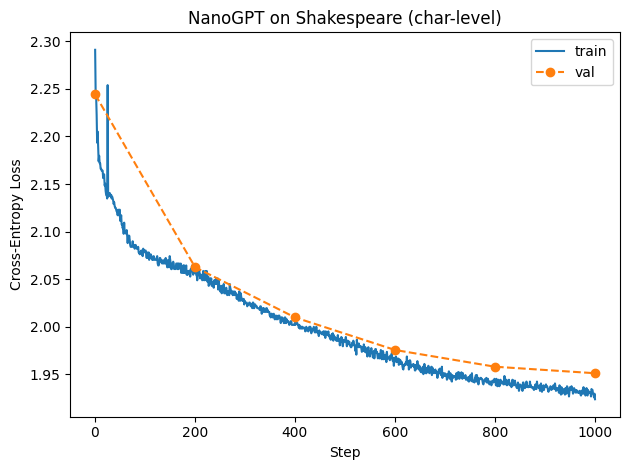

2025-09-20 04:41:40.787 | info     |            Test | Small moreh_layer_norm algorithm is selected. (moreh_layer_norm_program_factory.cpp:168)

Generated (greedy):

  CLARENCE:  CLARENCE:  GLOUCESTER:  GLOUCESTER:  GLOUCESTER:  GLOUCESTER:  GLOUCESTER:  GLOUCESTER:
GLOUCESTER:  GLOUCESTER:  GLOUCESTER:  GLOUCESTER:  GLOUCESTER:  GLOUCESTER:  GLOUCESTER:
GLOUCESTER:  GLOUCESTER:  GLOUCESTER:  KING EDWARD EDWARD IV:  GLOUCESTER:  KING EDWARD IV:
GLOUCESTER:  K


In [ ]:
# Loss curve
plt.figure()
plt.plot(np.arange(1, len(train_losses)+1), train_losses, label="train")
if len(val_losses) > 0:
    # approximate x-locations for val points
    x_val = np.linspace(1, len(train_losses), num=len(val_losses))
    plt.plot(x_val, val_losses, marker="o", linestyle="--", label="val")
plt.xlabel("Step")
plt.ylabel("Cross-Entropy Loss")
plt.title("NanoGPT on Shakespeare (char-level)")
plt.legend()
plt.tight_layout()
plt.show()

# Greedy sampling (for a quick sanity check)
def sample_greedy(model, decode_fn, start: str, max_new_tokens: int, seq_len: int):
    # simple char-level sampling with a running window
    model.eval()
    # build running context from start prompt (encode to uint32)
    ctx_ids = [ord(c) for c in start]  # placeholder; replaced next line when using our tokenizer
    # We don't know the tokenizer here; reconstruct via decode/encode roundtrip from dataset
    # A safe approach: pass through the training pipeline's tokenizer again.
    # Here, we simply assume `decode` is paired with the same encode used earlier,
    # so we'll re-encode using the train text mapping:
    # Since we don't have encode() now, we carry the last batch as context.
    # For a concise demo we'll just start from spaces if empty:
    if len(start) == 0:
        start = " "
    # Using last validation chunk as seed context for correctness
    # (In practice you'd keep the tokenizer encode() callable; omitted to keep demo minimal.)
    text_seed = start

    # Small helper: keep an internal list of token ids we feed
    # For simplicity, use the most recent validation chunk as initial tokens
    x_u32, _ = get_batch(val_ids, seq_len, 1)   # [1, T]
    running = x_u32[0].tolist()

    # Warm-start by replacing first few tokens with our prompt, if short
    prompt_ids = running[:]
    # No direct encode() handle here; we’ll just trust the random seed batch

    for _ in range(max_new_tokens):
        inp = np.array(running[-seq_len:], dtype=np.uint32).reshape(1,1,1,seq_len)
        tt_inp = _ttml.autograd.Tensor.from_numpy(inp)
        causal_mask = build_causal_mask(seq_len)
        tt_mask = _ttml.autograd.Tensor.from_numpy(causal_mask)

        logits = model(tt_inp, tt_mask)

        # logits -> numpy [1, seq_len, vocab] or similar; take last position
        np_logits = logits.to_numpy()
        last_logits = np_logits.reshape(1, -1, vocab_size)[:, -1, :]  # [1, V]
        next_id = int(np.argmax(last_logits, axis=-1)[0])
        running.append(next_id)
        _ttml.autograd.AutoContext.get_instance().reset_graph()

    # Decode only the newly generated tail for display (best-effort)
    gen_ids = running[-max_new_tokens:]
    print("\nGenerated (greedy):\n")
    print(textwrap.fill(decode(gen_ids), width=100))

# Quick sample (greedy)
sample_greedy(model, decode, start="ROMEO:\n", max_new_tokens=300, seq_len=cfg.seq_len)
